# IITM RL FINAL PROJECT

## Problem - bsuite 

This notebook uses an open source reinforcement learning benchmark known as bsuite. https://github.com/deepmind/bsuite

bsuite is a collection of carefully-designed experiments that investigate core capabilities of a reinforcement learning agent.

Your task is to use any reinforcement learning techniques at your disposal to get high scores on the environments specified.

**Note**: Since the course is on Reinforcement Learning,  please limit yourself to using traditional Reinforcement Learning algorithms, 

**Do not use deep reinforcement learning.**

# How to use this notebook? 📝

- This is a shared template and any edits you make here will not be saved. **You
should make a copy in your own drive**. Click the "File" menu (top-left), then "Save a Copy in Drive". You will be working in your copy however you like.

<p style="text-align: center"><img src="https://gitlab.aicrowd.com/aicrowd/assets/-/raw/master/notebook/aicrowd_notebook_submission_flow.png?inline=false" alt="notebook overview" style="width: 650px;"/></p>

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_RESULTS_DIR` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#install-packages-) section to install the packages

In [ ]:
!pip install -q aicrowd-cli

     |████████████████████████████████| 61kB 3.8MB/s 
     |████████████████████████████████| 61kB 3.9MB/s 
     |████████████████████████████████| 204kB 7.9MB/s 
     |████████████████████████████████| 81kB 6.4MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 174kB 8.5MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 71kB 5.9MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


# AIcrowd Runtime Configuration 🧷

Get login API key from https://www.aicrowd.com/participants/me


In [ ]:
import os

AICROWD_RESULTS_DIR = os.getenv("OUTPUTS_DIR", "results")
os.environ["RESULTS_DIR"] = AICROWD_RESULTS_DIR
API_KEY = "e9118f07e07f6266d2bed96dde8fe429"

In [ ]:
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


# Install packages 🗃

Please add all pacakage installations in this section

In [ ]:
!pip install git+http://gitlab.aicrowd.com/nimishsantosh107/bsuite.git
!pip install tabulate
!pip install tqdm

## Add any other installations you need here

  Cloning http://gitlab.aicrowd.com/nimishsantosh107/bsuite.git to /tmp/pip-req-build-i86esef7
  Running command git clone -q http://gitlab.aicrowd.com/nimishsantosh107/bsuite.git /tmp/pip-req-build-i86esef7
  Created wheel for bsuite: filename=bsuite-0.3.5-cp37-none-any.whl size=252058 sha256=a53df1ee5e0195e35c132566500e124e7e5f520052245a133eaa6a7c6e947438
  Stored in directory: /tmp/pip-ephem-wheel-cache-hg1onhtb/wheels/61/ea/06/77c82c07765fb8608e50e6c66bc566fa6d113c725bc6937e7b
Successfully built bsuite


# Import packages

In [ ]:
import gym
import warnings

import numpy as np
import pandas as pd
import plotnine as gg
from tqdm.notebook import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

import bsuite
from bsuite.aicrowd import environments
from bsuite.aicrowd.runner import Runner
from bsuite.aicrowd.analysis import Analyzer

pd.options.mode.chained_assignment = None
gg.theme_set(gg.theme_bw(base_size=16, base_family='serif'))
gg.theme_update(figure_size=(3, 1), panel_spacing_x=0.5, panel_spacing_y=0.5)
warnings.filterwarnings('ignore')

# **Agent Class**

You can modify the AGENT TEMPLATE below and implement the logic of your agent. Your agent must implement a few methods that will be called by the `Runner` class.
* `__init__` - put any initialization code here.
* `get_action` - takes in a `state` and returns an `action`.
* `learn` - takes in `(state, action, reward, next_state)`, implements the learning logic.
* `get_state` - takes in a raw `observation` directly from the env, discretizes it and returns a `state`.

In addition to these, you may implement other methods which can be called by the above methods.

Since there are multiple environments, you may need unique hyper parameters for each environment. Instantiate the agent while passing in the hyper parameters in a dictionary using the `agent_config` parameter so that each environment can use different hyper parameters for the agent while using a single `Agent` class for all of them.  You can use any names for the keys in the config dictionary.   

An example `RandomAgent` is given below.

In [ ]:
# *** YOU CAN EDIT THIS CELL ***
# AGENT TEMPLATE
class Agent:
    def __init__(self, agent_config=None):
        self.config = agent_config
        self.env_name = self.config['env_name']

        if self.env_name == 'cartpole' or self.env_name == 'cartpole_noise':
            self.epsilon = 0.99
            self.episode = 0
            self.pos_div = 0
            self.vel_div = 0
            self.theta_div = 3
            self.theta_dot_div = 3
            self.pos_array = np.linspace(-1,1, self.pos_div)
            self.vel_array = np.linspace(-5,5, self.vel_div)
            self.theta_array = np.linspace(-0.7, 0.7, self.theta_div)
            self.theta_dot_array = np.linspace(-5,5, self.theta_dot_div)
            self.action_number = 3
            self.Q = {}

            if self.env_name == 'cartpole_noise':
                self.cutoff = 100
                self.interval = 10
                self.alpha = 0.1
            else:
                self.alpha = 0.08
                self.cutoff = 100
                self.interval = 10
            self.gamma = 0.99

            for i in range(self.pos_div + 1):
                for j in range(self.vel_div + 1):
                    for k in range(self.theta_div + 1):
                        for l in range(self.theta_dot_div + 1):
                            for a in range(3):
                                self.Q.update({str(((i, j,k,l), a)) : 0})

        elif self.env_name == 'mountaincar' or self.env_name == 'mountaincar_noise':
            self.Q = {}
            self.alpha = 0.05
            self.gamma = 0.99
            self.num_pos = 5
            self.num_vel = 13
            self.pos_array = np.linspace(-1.2, 0.5, self.num_pos)
            self.vel_array = np.linspace(-0.07, 0.07, self.num_vel)

            self.es = np.zeros((self.num_pos + 1,self.num_vel + 1,3))

            for i in range(self.num_pos + 1):
                for j in range(self.num_vel + 1):
                    self.Q.update({str(((i, j), 0)) : 0})   
                    self.Q.update({str(((i, j), 2)) : 0})  
        
        elif self.env_name == 'catch' or self.env_name == 'catch_noise':
            self.Q = {}
            self.config = agent_config
            self.env_name = self.config['env_name']
            self.epsilon = 0.99
            self.episode = 0
            self.cutoff = 30
            self.interval = 10
            self.alpha = 0.1
            self.gamma = 0.99
            self.current_apple = -1

            for i in range(1):
                for j in range(1):
                    for k in range(-5,5):
                        for a in range(3):
                            self.Q.update({str(((k), a)) : 0}) 

    def get_action(self, state):
        '''
        PARAMETERS  : 
            - state - discretized 'state'
        RETURNS     : 
            - action - 'action' to be taken
        '''

        if self.env_name == 'cartpole' or self.env_name == 'cartpole_noise':
            temp = -np.inf
            if np.random.random() > self.epsilon:
                for a in range(3):
                    if self.Q[str((state, a))] > temp:
                        action = a
                        temp = self.Q[str((state, a))]
            else:
                '''
                temp = np.inf
                for a in range(3):
                    if self.Q[str((state, a))] < temp:
                        action = a
                        temp = self.Q[str((state, a))]
                '''
                action = np.random.randint(3)

        elif self.env_name == 'mountaincar' or self.env_name == 'mountaincar_noise':            
            if self.Q[str((state, 0))] > self.Q[str((state, 2))]:
                action = 0
            else:
                action = 2
        
        
        elif self.env_name == 'catch' or self.env_name == 'catch_noise':
            if np.random.random() > self.epsilon:
                temp = -np.inf
                for a in range(3):
                    if self.Q[str((state, a))] > temp:
                        action = a
                        temp = self.Q[str((state, a))]
            else:
                action = np.random.randint(3)

        #raise NotImplementedError
        return action
    
    def learn(self, state, action, reward, next_state, done):
        '''
        PARAMETERS  : 
            - state - discretized 'state'
            - action - 'action' performed in 'state'
            - reward - 'reward' received due to action taken
            - next_state - discretized 'next_state'
            - done - status flag to represent if an episode is done or not
        RETURNS     : 
            - NIL
        '''

        if self.env_name == 'cartpole' or self.env_name == 'cartpole_noise':
            max_value = -np.inf
            for a in range(3):
                if self.Q[str((next_state, a))] > max_value:
                    max_value = self.Q[str((next_state, a))]
            #print("before ",  self.Q[str((state, action))])
            #5/(2*self.theta*self.theta + 1)
            self.Q[str((state, action))] = deepcopy((1 - self.alpha)*self.Q[str((state, action))] + self.alpha*(reward  - 90*abs(self.theta) - 20*abs(self.pos)  +  self.gamma*max_value))

            #print("after ",  self.Q[str((state, action))])

        elif self.env_name == 'mountaincar' or self.env_name == 'mountaincar_noise':
            max_value = -np.inf
            if self.Q[str((next_state, 0))] > self.Q[str((next_state, 2))]:
                max_value = self.Q[str((next_state, 0))]
            else:
                max_value = self.Q[str((next_state, 2))]
            if self.env_name == 'mountaincar':
                self.Q[str((state, action))] = deepcopy((1 - self.alpha)*self.Q[str((state, action ))] + self.alpha*(reward + 3*self.pos  + 35*abs(self.vel)+ self.gamma*max_value))
            else:
                self.Q[str((state, action))] = deepcopy((1 - self.alpha)*self.Q[str((state, action ))] + self.alpha*(reward + 4*self.pos  + 36*abs(self.vel)+ self.gamma*max_value))
        
        elif self.env_name == 'catch' or self.env_name == 'catch_noise':
            max_value = -np.inf
            for a in range(3):
                if self.Q[str((next_state, a))] > max_value:
                    max_value = self.Q[str((next_state, a))]
            self.Q[str((state, action))] = deepcopy((1 - self.alpha)*self.Q[str((state, action ))] + self.alpha*(reward*10 +  self.gamma*max_value))
            if done == True:
                self.episode += 1


        #raise NotImplementedError

    def get_state(self, observation):
        '''
        PARAMETERS  : 
            - observation - raw 'observation' from environment
        RETURNS     : 
            - state - discretized 'state' from raw 'observation'
        '''
        if self.env_name == 'cartpole' or self.env_name == 'cartpole_noise':
            if observation[0][5] == 0:
                self.episode += 1             
                if (((self.episode+1) % self.interval) == 0): 
                    self.epsilon = deepcopy(self.epsilon - (0.99)/self.cutoff*self.episode)
            self.time = observation[0][5]
            self.vel = observation[0][1]
            self.pos = observation[0][0]
            sin = observation[0][2]
            cos = observation[0][3]
            self.theta = np.arctan2(sin, cos)
            self.theta_dot = observation[0][4]

            pos_index = int(np.digitize(self.pos, self.pos_array ))
            vel_index = int(np.digitize(self.vel, self.vel_array )) 
            theta_index = int(np.digitize(self.theta, self.theta_array )) 
            theta_dot_index = int(np.digitize(self.theta_dot, self.theta_dot_array ))
            
            state = (pos_index, vel_index, theta_index, theta_dot_index)
        
        elif self.env_name == 'mountaincar' or self.env_name == 'mountaincar_noise':
            self.pos = observation[0][0]
            self.vel = observation[0][1]
            pos_index = int(np.digitize(self.pos, self.pos_array ))
            vel_index = int(np.digitize(self.vel, self.vel_array )) 
            state = deepcopy((pos_index, vel_index)) 

        elif self.env_name == 'catch' or self.env_name == 'catch_noise':

            if (((self.episode+1) % self.interval) == 0): 
                self.epsilon = deepcopy(self.epsilon - (0.99)/self.cutoff*self.episode)
            x_pos = -1
            y_pos = -1
            pad = -1
            for i in range(9):
                for j in range(5):
                    if observation[i][j] == 1:
                        x_pos = i
                        y_pos = j
                        self.current_apple = j
            if x_pos == -1:
                for k in range(5):
                    if observation[9][k] == 1 and k != self.current_apple:
                        pad = k
                if pad == -1:
                    pad = self.current_apple  
            else:
                for k in range(5):
                    if observation[9][k] == 1:
                        pad = k
            state = ( y_pos -  pad)

        return state

In [ ]:
# *** YOU CAN EDIT THIS CELL ***
# DO NOT rename the config dictionaries as the evaluator references them. However, you may use any names for the keys in them.
catch_config = {"env_name": "catch"}
catch_noise_config = {"env_name": "catch_noise"}
cartpole_config = {"env_name": "cartpole"}
cartpole_noise_config = {"env_name": "cartpole_noise"}
mountaincar_config = {"env_name": "mountaincar"}
mountaincar_noise_config = {"env_name": "mountaincar_noise"}

In [ ]:
# *** YOU CAN EDIT THIS CELL ***
# EXAMPLE
class RandomAgent:
    def __init__(self, agent_config={}):
        self.config = agent_config
        self.env_name = self.config['env_name']

        if self.env_name == 'cartpole' or self.env_name == 'cartpole_noise':
            
            self.epsilon = 0.99
            self.episode = 0
            self.pos_div = 0
            self.vel_div = 0
            self.theta_div = 3
            self.theta_dot_div = 3
            self.pos_array = np.linspace(-1,1, self.pos_div)
            self.vel_array = np.linspace(-5,5, self.vel_div)
            self.theta_array = np.linspace(-0.7, 0.7, self.theta_div)
            self.theta_dot_array = np.linspace(-5,5, self.theta_dot_div)
            self.action_number = 3
            self.Q = {}

            if self.env_name == 'cartpole_noise':
                self.cutoff = 100
                self.interval = 10
                self.alpha = 0.1
            else:
                self.alpha = 0.08
                self.cutoff = 100
                self.interval = 10
            self.gamma = 0.99

            for i in range(self.pos_div + 1):
                for j in range(self.vel_div + 1):
                    for k in range(self.theta_div + 1):
                        for l in range(self.theta_dot_div + 1):
                            for a in range(3):
                                self.Q.update({str(((i, j,k,l), a)) : 0})   

    def get_action(self, state):
        if self.env_name == 'cartpole' or self.env_name == 'cartpole_noise':
            temp = -np.inf
            if np.random.random() > self.epsilon:
                for a in range(3):
                    if self.Q[str((state, a))] > temp:
                        action = a
                        temp = self.Q[str((state, a))]
            else:
                '''
                temp = np.inf
                for a in range(3):
                    if self.Q[str((state, a))] < temp:
                        action = a
                        temp = self.Q[str((state, a))]
                '''
                action = np.random.randint(3)
        
        return action
    
    def learn(self, state, action, reward, next_state, done):
        
        max_value = -np.inf
        for a in range(3):
            if self.Q[str((next_state, a))] > max_value:
                max_value = self.Q[str((next_state, a))]
        #print("before ",  self.Q[str((state, action))])
        #5/(2*self.theta*self.theta + 1)
        self.Q[str((state, action))] = deepcopy((1 - self.alpha)*self.Q[str((state, action))] + self.alpha*(reward  - 90*abs(self.theta) - 20*abs(self.pos)  +  self.gamma*max_value))
        #print("after ",  self.Q[str((state, action))])

    def get_state(self, observation):
        # In this function you're allowed to use 
        # the environment name for observation preprocessing
        # Do not use it anywhere else

        if self.env_name == 'cartpole' or self.env_name == 'cartpole_noise':
            if observation[0][5] == 0:
                self.episode += 1             
                if (((self.episode+1) % self.interval) == 0): 
                    self.epsilon = deepcopy(self.epsilon - (0.99)/self.cutoff*self.episode)
            self.time = observation[0][5]
            self.vel = observation[0][1]
            self.pos = observation[0][0]
            sin = observation[0][2]
            cos = observation[0][3]
            self.theta = np.arctan2(sin, cos)
            self.theta_dot = observation[0][4]

            pos_index = int(np.digitize(self.pos, self.pos_array ))
            vel_index = int(np.digitize(self.vel, self.vel_array )) 
            theta_index = int(np.digitize(self.theta, self.theta_array )) 
            theta_dot_index = int(np.digitize(self.theta_dot, self.theta_dot_array ))
            
            state = (pos_index, vel_index, theta_index, theta_dot_index)
        
        return state


# **Playing with the Environment**

#### **Instantiating the environment** :
You can create an environment by calling the following function:  
`environments.load_env(ENV_ID)` - RETURNS: `env`  
where, ENV_ID can be ONE of the following:
* `environments.CATCH`
* `environments.CATCH_NOISE`
* `environments.CARTPOLE`
* `environments.CARTPOLE_NOISE`
* `environments.MOUNTAINCAR`
* `environments.MOUNTAINCAR_NOISE`

The `NOISE` environments add a scaled random noise to the `reward`.
<br/>

#### **Runnning the environment** :
There are certain methods required to run the environments. The interface is very similar to OpenAI Gym's interfaces. Fore more information, read the OpenAI documentation [here](https://gym.openai.com/docs/).

`env.reset()` - RETURNS: `observation`  
`env.step(action)`  - RETURNS: `(next_observation, reward, done, info[NOT USED])`

There are also a few useful properties within the environments:

* `env.action_space.n` - total number of possible actions. eg: if 'n' is 3, then the possible actions are `[0, 1, 2]`
* `env.observation_space.shape` -  the shape of the observation.
* `env.bsuite_num_episodes` -  the pre-specified number of episodes which will be run during evaluation (unique for each environment).

##### *ONLY IN CATCH / CATCH_NOISE*
* `env.observation_space.high` -  the upper limit for every index in the observation.
* `env.observation_space.low` -  the lower limit for every index of the observation.
<br/>


## **Environment Observation Space Limits:**

The limits for the observation space (minimum and maximum) for all the environments are given in the table below:

| Environments                        | Limits                                                                      |
|-------------------------------------|-----------------------------------------------------------------------------|
| CATCH <br/>  CATCH_NOISE            | MIN: use `env.observation_space.low` <br/> MAX: use `env.observation_space.high` |
| CARTPOLE <br/> CARTPOLE_NOISE       | MIN: `[-1. -5., -1., -1., -5., 0.]` <br/> MAX: `[ 1.,  5.,  1.,  1.,  5., 1.]` |
| MOUNTAINCAR <br/> MOUNTAINCAR_NOISE | MIN: `[-1.2, -0.07, 0.]` <br/> MAX: `[ 0.6,  0.07,  1.]`                                 |

[NOTE] Use this code cell to play around and get used to the environments. However, the `Runner` class below will be used to evaluate your agent.

Loaded bsuite_id: cartpole/0.
-inf


  0%|          | 0/1000 [00:00<?, ?it/s]

EPISODE:  100 	REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  200 	REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  300 	REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  400 	REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  500 	REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  600 	REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  700 	REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  800 	REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  900 	REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  1000 	REWARD:  1001.0 	EPISODE_LENGTH:  1001
average under training 939.709090909091
episodes: 1000
{'((0, 0, 0, 0), 0)': 0, '((0, 0, 0, 0), 1)': 0, '((0, 0, 0, 0), 2)': 0, '((0, 0, 0, 1), 0)': 0, '((0, 0, 0, 1), 1)': 0, '((0, 0, 0, 1), 2)': 0, '((0, 0, 0, 2), 0)': 0, '((0, 0, 0, 2), 1)': 0, '((0, 0, 0, 2), 2)': 0, '((0, 0, 0, 3), 0)': 0, '((0, 0, 0, 3), 1)': 0, '((0, 0, 0, 3), 2)': 0, '((0, 0, 1, 0), 0)': 0, '((0, 0, 1, 0), 1)': 0, '((0, 0, 1, 0), 2)': 0, '((0, 0, 1, 1), 0)': -239.17489359460592, '

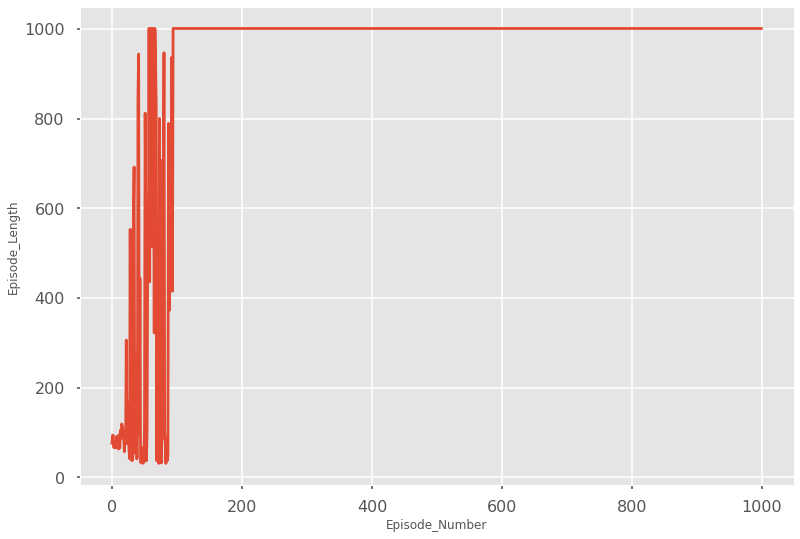

In [ ]:
# *** YOU CAN EDIT THIS CELL ***
# TEST AREA
env = environments.load_env(environments.CARTPOLE)  # replace 'environments.CARTPOLE' with other environments

agent = Agent(agent_config= cartpole_config)                # replace with 'Agent()' to use your custom agent

NUM_EPISODES = 1000       # replace with 'env.bsuite_num_episodes' to run for pre-specified number of episodes
episode_length = []
episode_number = []
position = []
#print(agent.weights)
print(-np.inf)
time = []
step = 0
for episode_n in tqdm(range(NUM_EPISODES)):
    
    done = False
    episode_reward = 0
    episode_moves = 0
 
    observation = env.reset()
    state = agent.get_state(observation)

    while not done:
        #print(agent.weights)
        action = agent.get_action(state)
        #print("action", action )
        
        
        next_observation, reward, done, _ = env.step(action)
        if episode_n%100:
            pass
            #print("position:", next_observation[0][0])
            #print("velocity:", next_observation[0][1])
        next_state = agent.get_state(next_observation)

        agent.learn(state, action, reward, next_state, done)

        state = next_state

        episode_reward += reward
        episode_moves += 1

    episode_length.append(episode_moves)
    episode_number.append(episode_n)

    if (((episode_n+1) % 100) == 0): 
        print("EPISODE: ",episode_n+1,"\tREWARD: ",episode_reward,"\tEPISODE_LENGTH: ",episode_moves)
        #print(done, agent.pos)
        #print(done, agent.theta)
        #print(done, agent.Q)
        #print("weights", agent.weights.round(2))
#print("episodes:", agent.episode)
#print(agent.Q.values())  
#print(len(list(agent.Q.values())))
plt.plot(episode_number, episode_length)
plt.xlabel("Episode_Number")
plt.ylabel("Episode_Length")
avg = []
for i in range(10, NUM_EPISODES):
    avg.append(sum(episode_length[i-10: i])/10)
#plt.plot(episode_number[0:len(avg)], avg)
#plt.plot(position, )
print("average under training", sum(avg)/len(avg))

#print("Q values",  agent.Q.values())
print("episodes:", agent.episode)
print(agent.Q)

## Point to the Agent Class you'll use for the final score

In [ ]:
RLAgent = RandomAgent
RLAgent1 = Agent

# **Evaluating the Agent on all the Environments**

* The following cells will take care of running your agent on each environment and aggregating the results in csv files. In each of the following cells, the `agent_config` parameter is already set to use the corresponding config dictionary for that environment. DO NOT EDIT THIS.
* Feel free to modify the `LOG_INTERVAL` parameter to change the interval between episodes for logging.  
* Please do not modify any other contents in each of the cells.  

In [ ]:
LOG_INTERVAL = 100

In [ ]:
runner = Runner(
    agent = RLAgent1(agent_config=catch_config),
    env_id = environments.CATCH,
    log_interval = LOG_INTERVAL,
)
runner.play_episodes()

Loaded bsuite_id: catch/0.
Logging results to CSV file for each bsuite_id in results.


  0%|          | 0/10000 [00:00<?, ?it/s]

EPISODE:  100 	REWARD:  1.0 	MEAN_REWARD:  0.7 	EPISODE_LENGTH:  9
EPISODE:  200 	REWARD:  1.0 	MEAN_REWARD:  1.0 	EPISODE_LENGTH:  9
EPISODE:  300 	REWARD:  1.0 	MEAN_REWARD:  1.0 	EPISODE_LENGTH:  9
EPISODE:  400 	REWARD:  1.0 	MEAN_REWARD:  1.0 	EPISODE_LENGTH:  9
EPISODE:  500 	REWARD:  1.0 	MEAN_REWARD:  1.0 	EPISODE_LENGTH:  9
EPISODE:  600 	REWARD:  1.0 	MEAN_REWARD:  1.0 	EPISODE_LENGTH:  9
EPISODE:  700 	REWARD:  1.0 	MEAN_REWARD:  1.0 	EPISODE_LENGTH:  9
EPISODE:  800 	REWARD:  1.0 	MEAN_REWARD:  1.0 	EPISODE_LENGTH:  9
EPISODE:  900 	REWARD:  1.0 	MEAN_REWARD:  1.0 	EPISODE_LENGTH:  9
EPISODE:  1000 	REWARD:  1.0 	MEAN_REWARD:  1.0 	EPISODE_LENGTH:  9
EPISODE:  1100 	REWARD:  1.0 	MEAN_REWARD:  1.0 	EPISODE_LENGTH:  9
EPISODE:  1200 	REWARD:  1.0 	MEAN_REWARD:  1.0 	EPISODE_LENGTH:  9
EPISODE:  1300 	REWARD:  1.0 	MEAN_REWARD:  1.0 	EPISODE_LENGTH:  9
EPISODE:  1400 	REWARD:  1.0 	MEAN_REWARD:  1.0 	EPISODE_LENGTH:  9
EPISODE:  1500 	REWARD:  1.0 	MEAN_REWARD:  1.0 	EPISODE_

In [ ]:
runner = Runner(
    agent = RLAgent1(agent_config=catch_noise_config),
    env_id = environments.CATCH_NOISE,
    log_interval = LOG_INTERVAL
)
runner.play_episodes()

Loaded bsuite_id: catch_noise/1.
Logging results to CSV file for each bsuite_id in results.


  0%|          | 0/10000 [00:00<?, ?it/s]

EPISODE:  100 	REWARD:  -0.4319180485080193 	MEAN_REWARD:  0.79 	EPISODE_LENGTH:  9
EPISODE:  200 	REWARD:  2.888194910660849 	MEAN_REWARD:  1.08 	EPISODE_LENGTH:  9
EPISODE:  300 	REWARD:  0.7058772924254098 	MEAN_REWARD:  0.97 	EPISODE_LENGTH:  9
EPISODE:  400 	REWARD:  0.5749511984405982 	MEAN_REWARD:  0.96 	EPISODE_LENGTH:  9
EPISODE:  500 	REWARD:  1.8165310035839968 	MEAN_REWARD:  1.07 	EPISODE_LENGTH:  9
EPISODE:  600 	REWARD:  0.39936420173707576 	MEAN_REWARD:  1.09 	EPISODE_LENGTH:  9
EPISODE:  700 	REWARD:  1.3884776851441103 	MEAN_REWARD:  0.91 	EPISODE_LENGTH:  9
EPISODE:  800 	REWARD:  1.8585504709523746 	MEAN_REWARD:  0.94 	EPISODE_LENGTH:  9
EPISODE:  900 	REWARD:  1.362278430457311 	MEAN_REWARD:  1.01 	EPISODE_LENGTH:  9
EPISODE:  1000 	REWARD:  1.829857544425355 	MEAN_REWARD:  1.05 	EPISODE_LENGTH:  9
EPISODE:  1100 	REWARD:  -0.37396752528475785 	MEAN_REWARD:  1.03 	EPISODE_LENGTH:  9
EPISODE:  1200 	REWARD:  0.9410664532715053 	MEAN_REWARD:  1.04 	EPISODE_LENGTH:  9


In [ ]:
runner = Runner(
    agent = RLAgent(agent_config=cartpole_config),
    env_id = environments.CARTPOLE,
    log_interval = LOG_INTERVAL
)
runner.play_episodes()

Loaded bsuite_id: cartpole/0.
Logging results to CSV file for each bsuite_id in results.


  0%|          | 0/1000 [00:00<?, ?it/s]

EPISODE:  100 	REWARD:  1001.0 	MEAN_REWARD:  496.97 	EPISODE_LENGTH:  1001
EPISODE:  200 	REWARD:  1001.0 	MEAN_REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  300 	REWARD:  1001.0 	MEAN_REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  400 	REWARD:  1001.0 	MEAN_REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  500 	REWARD:  1001.0 	MEAN_REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  600 	REWARD:  1001.0 	MEAN_REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  700 	REWARD:  1001.0 	MEAN_REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  800 	REWARD:  1001.0 	MEAN_REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  900 	REWARD:  1001.0 	MEAN_REWARD:  1001.0 	EPISODE_LENGTH:  1001
EPISODE:  1000 	REWARD:  1001.0 	MEAN_REWARD:  1001.0 	EPISODE_LENGTH:  1001


In [ ]:
runner = Runner(
    agent = RLAgent(agent_config=cartpole_noise_config),
    env_id = environments.CARTPOLE_NOISE,
    log_interval = LOG_INTERVAL
)
runner.play_episodes()

Loaded bsuite_id: cartpole_noise/1.
Logging results to CSV file for each bsuite_id in results.


  0%|          | 0/1000 [00:00<?, ?it/s]

EPISODE:  100 	REWARD:  996.3318165731581 	MEAN_REWARD:  553.37 	EPISODE_LENGTH:  1001
EPISODE:  200 	REWARD:  996.7377139991345 	MEAN_REWARD:  861.9 	EPISODE_LENGTH:  1001
EPISODE:  300 	REWARD:  999.8642715737213 	MEAN_REWARD:  1001.2 	EPISODE_LENGTH:  1001
EPISODE:  400 	REWARD:  996.736341146314 	MEAN_REWARD:  1001.37 	EPISODE_LENGTH:  1001
EPISODE:  500 	REWARD:  998.5172213113141 	MEAN_REWARD:  1000.01 	EPISODE_LENGTH:  1001
EPISODE:  600 	REWARD:  990.6613848778835 	MEAN_REWARD:  1001.33 	EPISODE_LENGTH:  1001
EPISODE:  700 	REWARD:  1000.1861916747147 	MEAN_REWARD:  1001.78 	EPISODE_LENGTH:  1001
EPISODE:  800 	REWARD:  997.082800169004 	MEAN_REWARD:  1001.27 	EPISODE_LENGTH:  1001
EPISODE:  900 	REWARD:  1007.6381185393742 	MEAN_REWARD:  1000.91 	EPISODE_LENGTH:  1001
EPISODE:  1000 	REWARD:  993.1746945001216 	MEAN_REWARD:  999.38 	EPISODE_LENGTH:  1001


In [ ]:
runner = Runner(
    agent = RLAgent1(agent_config=mountaincar_config),
    env_id = environments.MOUNTAINCAR,
    log_interval = LOG_INTERVAL
)
runner.play_episodes()

Loaded bsuite_id: mountain_car/0.
Logging results to CSV file for each bsuite_id in results.


  0%|          | 0/1000 [00:00<?, ?it/s]

EPISODE:  100 	REWARD:  -120.0 	MEAN_REWARD:  -220.48 	EPISODE_LENGTH:  120
EPISODE:  200 	REWARD:  -114.0 	MEAN_REWARD:  -164.66 	EPISODE_LENGTH:  114
EPISODE:  300 	REWARD:  -120.0 	MEAN_REWARD:  -177.08 	EPISODE_LENGTH:  120
EPISODE:  400 	REWARD:  -110.0 	MEAN_REWARD:  -167.84 	EPISODE_LENGTH:  110
EPISODE:  500 	REWARD:  -110.0 	MEAN_REWARD:  -124.06 	EPISODE_LENGTH:  110
EPISODE:  600 	REWARD:  -131.0 	MEAN_REWARD:  -126.32 	EPISODE_LENGTH:  131
EPISODE:  700 	REWARD:  -118.0 	MEAN_REWARD:  -128.55 	EPISODE_LENGTH:  118
EPISODE:  800 	REWARD:  -110.0 	MEAN_REWARD:  -113.55 	EPISODE_LENGTH:  110
EPISODE:  900 	REWARD:  -110.0 	MEAN_REWARD:  -124.78 	EPISODE_LENGTH:  110
EPISODE:  1000 	REWARD:  -114.0 	MEAN_REWARD:  -113.19 	EPISODE_LENGTH:  114


In [ ]:
runner = Runner(
    agent = RLAgent1(agent_config=mountaincar_noise_config),
    env_id = environments.MOUNTAINCAR_NOISE,
    log_interval = LOG_INTERVAL
)
runner.play_episodes()

Loaded bsuite_id: mountain_car_noise/1.
Logging results to CSV file for each bsuite_id in results.


  0%|          | 0/1000 [00:00<?, ?it/s]

EPISODE:  100 	REWARD:  -212.3082643451326 	MEAN_REWARD:  -251.82 	EPISODE_LENGTH:  215
EPISODE:  200 	REWARD:  -215.77531570710465 	MEAN_REWARD:  -174.18 	EPISODE_LENGTH:  223
EPISODE:  300 	REWARD:  -205.27938277036907 	MEAN_REWARD:  -181.11 	EPISODE_LENGTH:  203
EPISODE:  400 	REWARD:  -126.93837394654527 	MEAN_REWARD:  -131.81 	EPISODE_LENGTH:  122
EPISODE:  500 	REWARD:  -158.8581514350934 	MEAN_REWARD:  -121.12 	EPISODE_LENGTH:  165
EPISODE:  600 	REWARD:  -105.98287312618042 	MEAN_REWARD:  -117.34 	EPISODE_LENGTH:  109
EPISODE:  700 	REWARD:  -111.10347776813909 	MEAN_REWARD:  -130.93 	EPISODE_LENGTH:  109
EPISODE:  800 	REWARD:  -118.0130018567444 	MEAN_REWARD:  -132.37 	EPISODE_LENGTH:  118
EPISODE:  900 	REWARD:  -113.0726430891401 	MEAN_REWARD:  -116.49 	EPISODE_LENGTH:  110
EPISODE:  1000 	REWARD:  -110.87285008720426 	MEAN_REWARD:  -118.21 	EPISODE_LENGTH:  117


# **Analysis & Result**

The following cells will show the score of the agent on each environment. The same scoring method will be used to evaluate your agent on a set of test environments.

In [ ]:
# *** PLEASE DONT EDIT THE CONTENTS OF THIS CELL ***
analyzer = Analyzer(os.environ.get('RESULTS_DIR'))
analyzer.print_scores()

╒════════════════════╤══════════╕
│ ENVIRONMENT        │    SCORE │
╞════════════════════╪══════════╡
│ catch              │ 0.998125 │
├────────────────────┼──────────┤
│ catch_noise        │ 0.99825  │
├────────────────────┼──────────┤
│ cartpole           │ 0.975299 │
├────────────────────┼──────────┤
│ cartpole_noise     │ 0.971099 │
├────────────────────┼──────────┤
│ mountain_car       │ 0.953949 │
├────────────────────┼──────────┤
│ mountain_car_noise │ 0.952333 │
╘════════════════════╧══════════╛


In [ ]:
# If you want a object to get the scores
analyzer.get_scores()

{'cartpole': 0.9752985000000001,
 'cartpole_noise': 0.9710989999999999,
 'catch': 0.998125,
 'catch_noise': 0.9982500000000001,
 'mountain_car': 0.9539489999999999,
 'mountain_car_noise': 0.952333}

## What is the score function

The score function is developed by the BSuite team at Deepmind. It is open source and available at https://github.com/deepmind/bsuite

The score measures behavioral aspects of the agent only, and does not take into account internal state of the agent. For more details read Section 2 of the [BSuite paper](https://openreview.net/forum?id=rygf-kSYwH). In this case we use only the "Basic" aspect of the agent's scoring system.

**It is not necessary to understand the score in order to improve your agent's performance**

# **Backend Evaluation**

THIS CODE WILL EVALUATE THE AGENT USING THE SPECIFIED CONFIGS FOR THE CORRESPONDING ENVIRONMENTS. DO NOT EDIT THE CONTENTS OF THIS CELL.

In [ ]:
## Do not edit this cell
if (os.environ.get('BACKEND_EVALUATOR') is not None):
    
    import backend_evaluator

    runs = {
        'catch': (
            backend_evaluator.CATCH, 
            catch_config),
        'catch_noise': (
            backend_evaluator.CATCH_NOISE, 
            catch_noise_config),
        'cartpole': (
            backend_evaluator.CARTPOLE, 
            cartpole_config),
        'cartpole_noise': (
            backend_evaluator.CARTPOLE_NOISE, 
            cartpole_noise_config),
        'mountaincar': (
            backend_evaluator.MOUNTAINCAR, 
            mountaincar_config),
        'mountaincar_noise': (
            backend_evaluator.MOUNTAINCAR_NOISE, 
            mountaincar_noise_config)
    }

    for run_name, run in runs.items():
        env_ids, config = run
        for env_id in env_ids:
            runner = Runner(env_id=env_id,
                            agent=RLAgent(agent_config=config),
                            verbose=False,
                            eval=True)
            runner.play_episodes()

# Submit to AIcrowd 🚀

**NOTE: PLEASE SAVE THE NOTEBOOK BEFORE SUBMITTING IT (Ctrl + S)**

In [ ]:
! aicrowd notebook submit --no-verify -c iitm-rl-final-project -a assets

Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7GbK62SPaGCEmiIfhtRfMkduYY4ypqzLM9Q-kZ8huyOJQyO9se7gY
Mounted at /content/drive
Using notebook: /content/drive/MyDrive/Colab Notebooks/IITM_RL_Final_Project_Release.ipynb for submission...
Scrubbing API keys from 